
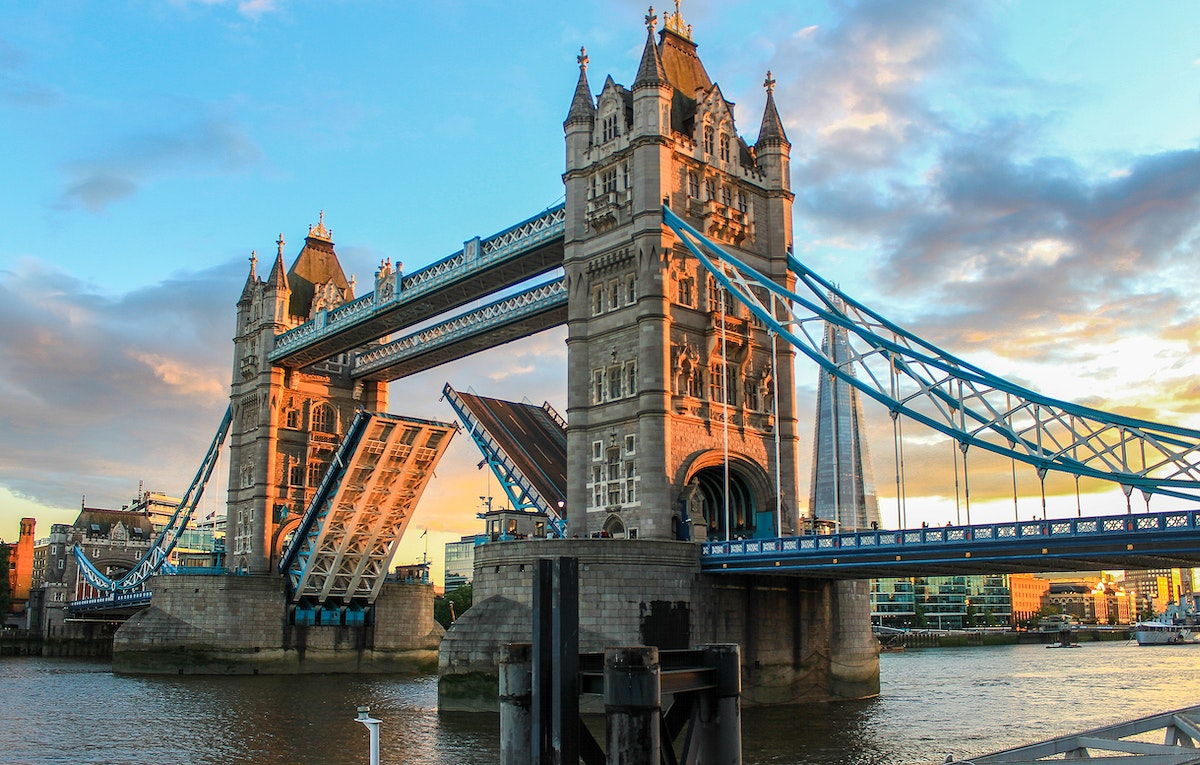


# As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of sklearn and MLflow.

You will be working with data stored in london_weather.csv, which contains the following columns:


*  date - recorded date of measurement - (int)
*  cloud_cover - cloud cover measurement in oktas - (float)

*  sunshine - sunshine measurement in hours (hrs) - (float)
*  global_radiation - irradiance measurement in Watt per square meter (W/m2) - (float)


*   max_temp - maximum temperature recorded in degrees Celsius (°C) - (float)
*   mean_temp - mean temperature in degrees Celsius (°C) - (float)


*  min_temp - minimum temperature recorded in degrees Celsius (°C) - (float)
*  precipitation - precipitation measurement in millimeters (mm) - (float)


*   pressure - pressure measurement in Pascals (Pa) - (float)
*   snow_depth - snow depth measurement in centimeters (cm) - (float) italicized text











### Importing the Library

In [46]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import matplotlib.pyplot as plt

### Load The Data

In [63]:
# Load data and perform exploratory analysis
weather=pd.read_csv('london_weather.csv')
weather.head(5)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


### Exploratory data analysis

In [64]:
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()



### Data visualization

<ipython-input-72-d95e4feac35d>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)


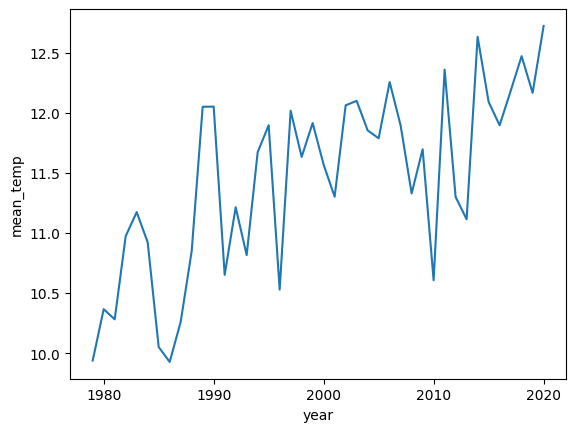

In [72]:
sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
plt.show()

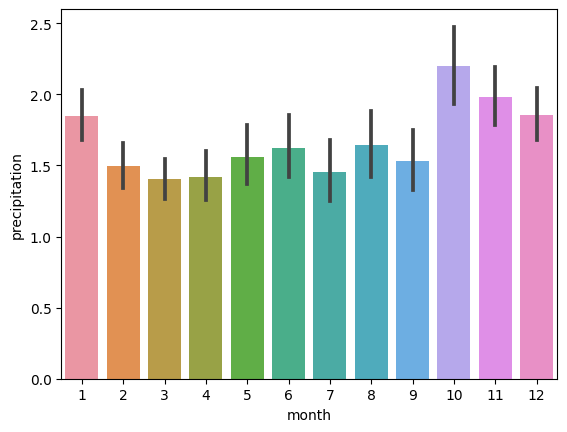

In [73]:
sns.barplot(x='month', y='precipitation', data=weather)
plt.show()

<ipython-input-75-0b8437c3cdef>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(weather.corr(), annot=True)


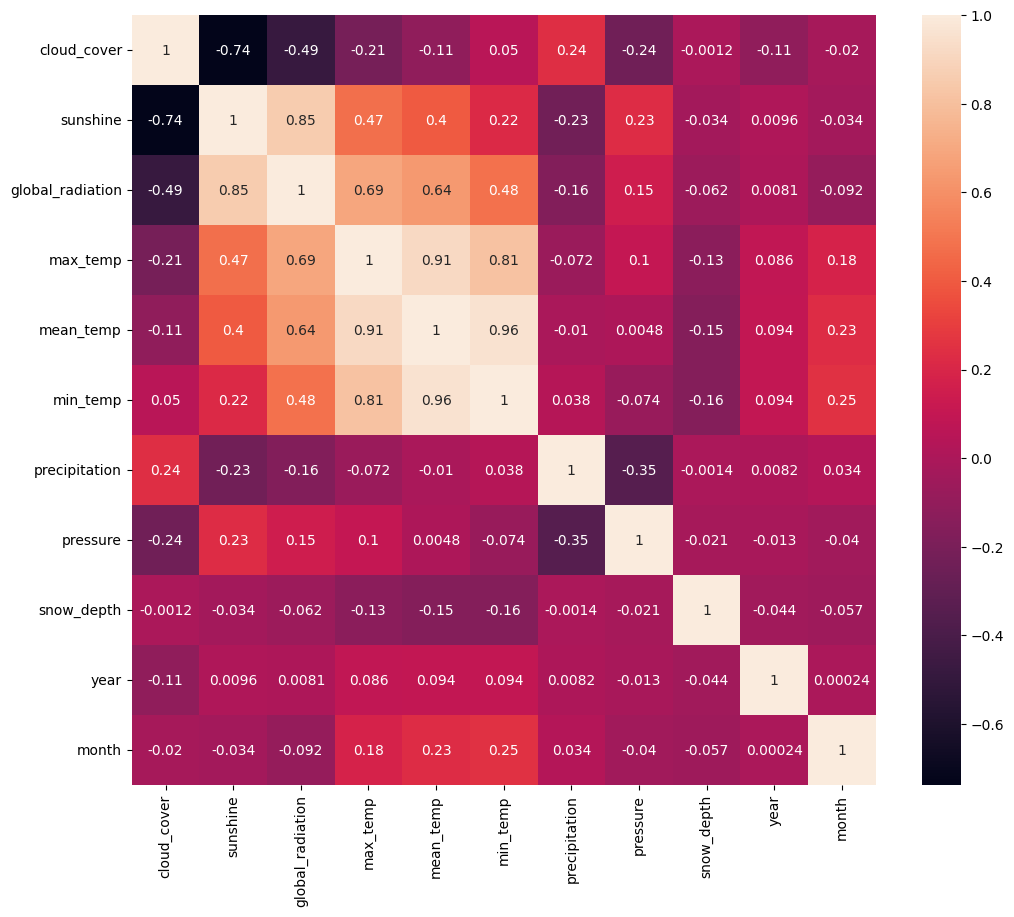

In [75]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(weather.corr(), annot=True)
plt.show()

### Feature selection and Preprocess data

In [66]:
# Choose features, define the target, and drop null values
feature_selection = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
target_var = 'mean_temp'
weather = weather.dropna(subset=['mean_temp'])


In [67]:
def preprocess_df(df, feature_selection, target_var):
    """
    Split dataframe into X and y, and train and test consecutively. Then impute and scale both train and test features. Returns the train and test ets
    """
    # Complete this function
    X = df[feature_selection]    
    y = df[target_var]
    #split the data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # simple imputer to fill the null value  
    imp_data=SimpleImputer(strategy='mean')
    X_train=imp_data.fit_transform(X_train)
    X_test=imp_data.transform(X_test)
    # Scale The Data 
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = preprocess_df(weather, feature_selection, target_var)

### Machine learning training and evaluation

In [61]:
def predict_and_evaluate(model, x_test, y_test):
    """
    Predict values from test set, calculate and return the root mean squared error.
    """
    y_pred=model.predict(x_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    
    return rmse

In [77]:
EXPERIMENT_NAME = "mohammadEx"

# Check if the experiment already exists, if not create a new one
if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# Adjust the parameters
max_depth_parameters = [1, 2]

for idx, depth in enumerate([1, 2, 5, 10, 20]):
    parameters = {
        'max_depth': depth,
        'random_state': 1
    }    
    RUN_NAME = f"run_{idx}"
    # Complete the experiment loop
    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME):
        # Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        lin_reg_rmse = predict_and_evaluate(lin_reg, X_test, y_test)
        tree_reg_rmse = predict_and_evaluate(tree_reg, X_test, y_test)
        forest_reg_rmse = predict_and_evaluate(forest_reg, X_test, y_test)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)

experiment_results = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_fr,metrics.rmse_lr,metrics.rmse_tr,params.max_depth,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.user
0,e93a81c02b6448788b1759d50c0e9930,508681390190673367,FINISHED,file:///content/mlruns/508681390190673367/e93a...,2023-05-31 13:54:28.248000+00:00,2023-05-31 13:54:40.642000+00:00,2.878634,3.673185,3.930670,20,LOCAL,run_4,/usr/local/lib/python3.10/dist-packages/ipyker...,"[{""run_id"": ""e93a81c02b6448788b1759d50c0e9930""...",root
1,c768aa5b72094a7897dc14650e10dba3,508681390190673367,FINISHED,file:///content/mlruns/508681390190673367/c768...,2023-05-31 13:54:18.141000+00:00,2023-05-31 13:54:28.244000+00:00,2.788197,3.673185,3.038971,10,LOCAL,run_3,/usr/local/lib/python3.10/dist-packages/ipyker...,"[{""run_id"": ""c768aa5b72094a7897dc14650e10dba3""...",root
2,9a3fb3d637444e929af1327c1f32b8dd,508681390190673367,FINISHED,file:///content/mlruns/508681390190673367/9a3f...,2023-05-31 13:54:09.636000+00:00,2023-05-31 13:54:18.136000+00:00,2.920368,3.673185,2.969909,5,LOCAL,run_2,/usr/local/lib/python3.10/dist-packages/ipyker...,"[{""run_id"": ""9a3fb3d637444e929af1327c1f32b8dd""...",root
3,073ef87c5ffb46b28c833bf92e42e179,508681390190673367,FINISHED,file:///content/mlruns/508681390190673367/073e...,2023-05-31 13:54:01.133000+00:00,2023-05-31 13:54:09.631000+00:00,3.778498,3.673185,3.855133,2,LOCAL,run_1,/usr/local/lib/python3.10/dist-packages/ipyker...,"[{""run_id"": ""073ef87c5ffb46b28c833bf92e42e179""...",root
4,4c0370d262024080929f1b366533db92,508681390190673367,FINISHED,file:///content/mlruns/508681390190673367/4c03...,2023-05-31 13:53:49.378000+00:00,2023-05-31 13:54:01.128000+00:00,4.621091,3.673185,4.686188,1,LOCAL,run_0,/usr/local/lib/python3.10/dist-packages/ipyker...,"[{""run_id"": ""4c0370d262024080929f1b366533db92""...",root
